## Midterm BME 502 2025

In this midterm exam, you are tasked to develop a method to tell whether data is better described by a line fit or a sigmoidal fit.

In [169]:
import Pkg
Pkg.activate(".")

  Activating project at `d:\Git_Repos\Julia\BME-502-2025-homeworks`


In [170]:
Pkg.add(["Plots","Distributions","Random","Statistics","LsqFit","ForwardDiff"])

   Resolving package versions...
  No Changes to `D:\Git_Repos\Julia\BME-502-2025-homeworks\Project.toml`
  No Changes to `D:\Git_Repos\Julia\BME-502-2025-homeworks\Manifest.toml`


In [171]:
using Plots, Distributions, Random, Statistics, LsqFit, ForwardDiff, LinearAlgebra

In [172]:
line_fit(x,p) = p[1] .+ p[2] .* x

line_fit (generic function with 1 method)

In [173]:
sigmoid_fit(x,p) = p[1] .+ p[2] ./ (1 .+ exp.(-p[3]*(x .- p[4])))

sigmoid_fit (generic function with 1 method)

Let's create some plots to see how these functions look

In [174]:
x = 0:0.1:10

0.0:0.1:10.0

In [175]:
y_line = line_fit(x,[2,0.5])

2.0:0.05:7.0

In [176]:
y_sigmoid = sigmoid_fit(x,[2.5,3.5,0.1,5.5])

101-element Vector{Float64}:
 3.7805254314621974
 3.788656537923644
 3.796809108114118
 3.8049828179038157
 3.8131773393604975
 3.8213923407935093
 3.8296274867991844
 3.837882438307629
 3.8461568526308625
 3.854450383512326
 ⋮
 4.57010642451473
 4.5785558602695
 4.586989447538757
 4.595406810393582
 4.603807575969294
 4.612191374526542
 4.620557839511163
 4.6289066076128
 4.637237318822277

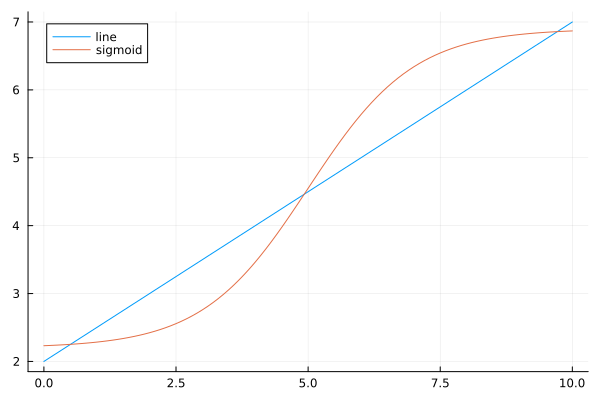

In [177]:
y_line = line_fit(x,[2,0.5])
y_sigmoid = sigmoid_fit(x,[2.2,4.7,1,5.0])
plot(x, y_line, label = "line")
plot!(x, y_sigmoid, label = "sigmoid")

Let us add some serious noise to it

In [178]:
nd = Normal(0,5)
x_line = 10*rand(200)
y_line_n = line_fit(x_line,[2,0.5]) .+ rand(nd,length(x_line))
x_sigmoid = 10*rand(200)
y_sigmoid_n = sigmoid_fit(x_sigmoid,[2.2,4.7,1,5.0]) .+ rand(nd,length(x_sigmoid))

200-element Vector{Float64}:
  0.8060979166656419
 -2.8974711945162674
  4.339886589652248
 -3.9329151659898023
 14.081249861276227
 10.354694435695178
  5.3399260304305995
  1.1635695345698034
  4.334970109824829
 10.615257120692142
  ⋮
  3.96131008984678
 -0.6516738716889483
  5.8083536847712605
  1.3515878509679258
  9.172553391624135
  2.1640748477338065
  4.7505561065900395
  9.78529089614539
 -5.202792178694147

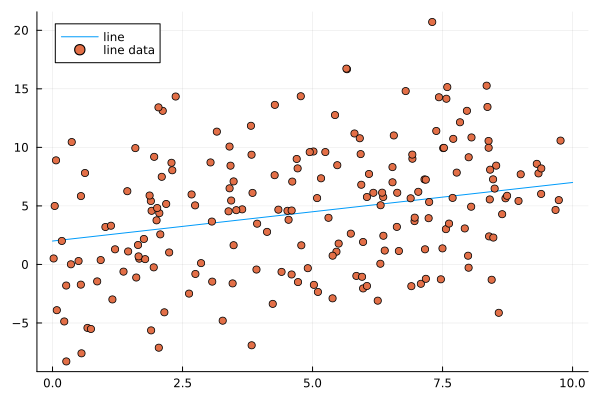

In [179]:
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")

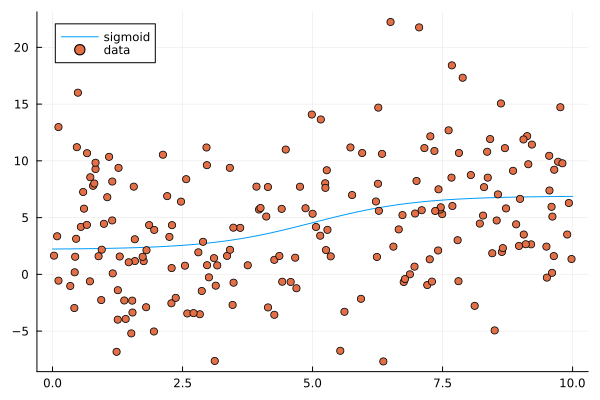

In [180]:
plot(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "data")

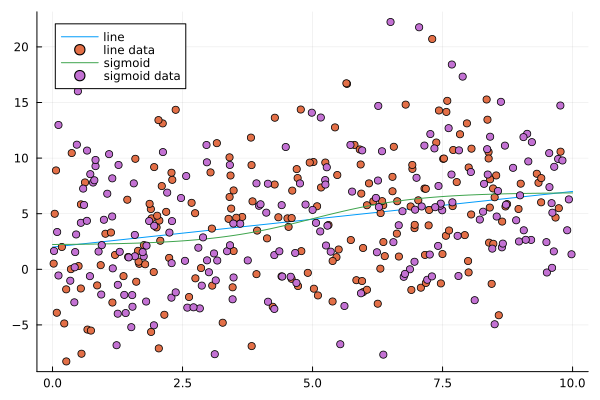

In [181]:
# let's plot it all together
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")
plot!(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "sigmoid data")

# Question:

If you take the sigmoid data, which fit is better? The linear or sigmoid?

How uncertain are the parameters?

At what noise level are the two fits equally likely?

# Part 1 (20 points)
Create a function line_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix.  The standard deviation of the measurement error, sigma, can be supplied as a number (assuming that all measurements share the same error) or as a vector with the same length as y. If sigma (standard deviation of measurement error) is not specified (sigma=[]), estimate the measurement error using the sum of least squares to estimate $\mathcal{X}^2$.

In [182]:
res(fitfct,β,(x,y)) = fitfct(x,β) .- y 

function lsqfitting(fitfct, (x,y), β0) 
    fit = curve_fit(fitfct, x, y, β0)
    return fit
end

function curve_fitting(fitfct,num_params,x,y,σ,returnchi2) #returns best parameters, covariance matrix
    initial_guess = repeat([1.0],num_params)
    fit = lsqfitting(fitfct, (x,y), initial_guess) 
    β = fit.param
    # chi2val = 0
    if σ == []
        covar_mat = estimate_covar(fit)
        chisq1(β) = sum(abs2,(res(line_fit,β,(x,y))) ./ line_fit(x,β))
        chi2val = chisq1(β)
    else #should work for either scalar or vector
        chisq2(β) = sum(abs2,(fitfct(x,β) .- y) ./ σ)
        covar_mat = inv(2*ForwardDiff.hessian(chisq2,fit.param))
        chi2val = chisq2(β)
    end
    # cov = sqrt.(covar_mat[diagind(covar_mat)]) #Note: it's the square root of the diagonals that gives the stdev
    if returnchi2
        return β,covar_mat,chi2val
    else
        return β,covar_mat
    end
end

curve_fitting (generic function with 2 methods)

In [183]:
line_fitting(x,y;σ=[],returnchi2=false) = curve_fitting(line_fit,2,x,y,σ,returnchi2)

line_fitting (generic function with 1 method)

In [184]:
line_fitting(x_line,y_line_n,σ=4,returnchi2=true)

([1.3648112026931034, 0.6660081647480315], [0.08509300333739346 -0.013346022923752069; -0.013346022923752069 0.0027363359923353644], 320.665456351237)

In [185]:
line_fitting(x_line,y_line_n) 

([1.3648112026931034, 0.6660081647480315], [0.5512401363071393 -0.08645673800496477; -0.08645673800496477 0.017726230902915047])

# Part 2 (20 points)
Similarily, create a function sigmoid_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix. Treat sigma the same way as in Part 1.

In [186]:
sigmoid_fitting(x,y;σ=[],returnchi2=false) = curve_fitting(sigmoid_fit,4,x,y,σ,returnchi2)

sigmoid_fitting (generic function with 1 method)

In [187]:
sigmoid_fitting(x_sigmoid, y_sigmoid_n) 

([2.6462671714323864, 3.6528232773695364, 2.1492751955499103, 4.942438464621594], [0.37764787528107624 -0.4083884990857332 0.6118517973165644 0.12986974724500688; -0.4083884990857332 0.831109838710949 -1.2221995164805664 0.005684553080223114; 0.6118517973165644 -1.2221995164805664 8.231177071540511 -0.028598648150956224; 0.12986974724500688 0.005684553080223114 -0.028598648150956224 0.4534831871940663])

In [ ]:
sigmoid_fitting(x_sigmoid, y_sigmoid_n,σ=3) #if the data is too weird, I get errors here

([2.6462671714323864, 3.6528232773695364, 2.1492751955499103, 4.942438464621594], [0.027189411133308625 -0.025757603208614234 -0.0007062957931672362 0.011392323720468006; -0.02575760320861424 0.07954843500747398 -0.17839039284623082 0.04665139038469333; -0.0007062957931671808 -0.1783903928462309 1.194841470503013 -0.31164857341949137; 0.011392323720467997 0.04665139038469335 -0.31164857341949137 0.1197848378931988])

# Part 3 (30 points)
Create a function p_ratio_sig_line(x,y; sigma=[]) that returns the Posterior ratio between a fit to a sigmoid and to a line.  Treat sigma the same way as in Part 1-2.

In [189]:
function p_ratio_sig_line(x,y;σ=[]) 
    # p_sig(x,y,sigma)/p_line(x,y,sigma)
    linbeta, lincov, linchi2best = line_fitting(x,y,σ=σ,returnchi2=true)
    sigbeta, sigcov, sigchi2best = sigmoid_fitting(x,y,σ=σ,returnchi2=true)
    lin_params=2
    sig_params=4
    print(det(lincov))
    print("\n")
    print(det(sigcov)) #this always seems to be negative w/ sigma specified for some reason 

    pr = exp(-(linchi2best-sigchi2best)/2)*sqrt(det(lincov)/det(sigcov))/sqrt(2*π)^(sig_params-lin_params) *0.5 #where does this 0.5 come from??
    return pr
end

p_ratio_sig_line (generic function with 1 method)

In [199]:
p_ratio_sig_line(x_line,y_line_n,σ=1)

2.1377624940120028e-7
5.580090684033346

4.111838186384462e-14

In [194]:
p_ratio_sig_line(x_line,y_line_n)

0.0022966423926755967
-2.0957308432479347e14

DomainError: DomainError with -1.095867057582782e-17:
sqrt was called with a negative real argument but will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

# Part 4 (30 points)
Create a function sig_p_ratio_is_one(x,y; sigma=[]) that returns the measurement error (either as a number or array depending on how the sigma is supplied) that would result in a posterior ratio between sigmoid and line of one. If sigma is not provided (sigma=[]), proceed as in Part 1-3.

## Programming Advice:
To make your program more efficient you should think about creating functions that provide information that you can use for all of the parts.  Don't write each function individually, but think what are the common task that need to be done, and then call these more general functions, to get you the result for the specific questions.  I will reward good programming style with a bonus 10 points total.